 01_exploration.ipynb
 ---------------------
 Purpose:
 - This notebook is purely for EXPLORING the raw dataset.
 - It does NOT train any models.
 - It helps us understand the structure, quality, and basic relationships in the data
   before we decide how to model it.

 What this notebook does:
 1. Load the raw dataset using the shared project code (load_raw_data).
 2. Inspect basic structure:
    - Number of rows and columns (df.shape).
    - Column names and data types (df.info).
    - Summary statistics for numeric columns (df.describe).
    - Summary statistics for categorical columns (df.describe(include="object")).
 3. Explore the target variable (price):
    - Plot the distribution of the target (histogram + KDE).
    - Check for skewness and long tails that might affect modelling.
 4. Explore input features:
    - For NUMERIC_FEATURES:
         - Plot histograms to see their distributions (e.g. spread, outliers, skew).
    - For CATEGORICAL_FEATURES:
         - Plot bar charts of category frequencies to see dominant or rare categories.
 5. Check relationships to the target:
    - Compute and plot a correlation matrix between numeric features and the target.
    - This shows which features are strongly associated with the target and which are not.
 6. Diagnose multicollinearity:
    - Use Variance Inflation Factor (VIF) on NUMERIC_FEATURES.
    - Very high VIF means a feature can be explained by other numeric features.
    - High multicollinearity signals that plain linear regression coefficients will be unstable.

 What this notebook explicitly does NOT do:
 - No model training (no LinearRegression, Ridge, Lasso, etc.).
 - No train/test split.
 - No residual plots, Q-Q plots, or model diagnostics.

 How this notebook fits into the overall workflow:
 - This is step 1: understand the data.
 - The insights here (skewness, outliers, multicollinearity) directly inform:
     - Why we log-transform the target later.
     - Why we prefer Ridge/Lasso over plain OLS.
     - Which features might need extra care or engineering.
 - Model training and comparison are handled in 02_model_comparison.ipynb.
 - Model diagnostics and interpretation for the final chosen model are handled in
   03_model_diagnostics.ipynb.


1) Understand the data

- View sample rows (head, sample)
- Check dataset shape (rows, columns)
- Identify types: numeric, categorical, date, text

2) Data quality checks

- Count missing values per column
- Detect duplicates
- Summary stats: mean, median, std, min/max, skewness
- Check inconsistent values (e.g., negative prices, impossible ages)

3) Target variable exploration (y)

- Distribution plot (histogram, KDE)
- Check skewness → consider log transform if skewed
- Detect outliers (boxplot, percentile inspection)

4) Univariate exploration (each feature separately)

For numeric predictors:
- Histograms, boxplots
- Check skewness, outliers

For categorical predictors:
- Frequency counts + bar charts
- Rare category detection

5) Bivariate exploration (feature ↔ target)

Numeric vs target:
- Scatterplot with regression line
- Correlation (Pearson)

Categorical vs target:
- Grouped boxplots
- Group means / confidence intervals

6) Collinearity diagnostics

- Correlation heatmap (numeric features only)
- Identify highly correlated pairs (|r| > 0.8)
- Variance Inflation Factors (VIF) where appropriate

7) Relationship patterns

Look for nonlinear forms:
- curved scatter shapes
- heteroscedasticity (changing spread)

Note if transformations may help:
- log, quadratic, interactions

8) Data transformations to consider

- Log scaling for skewed variables
- Standardisation/normalisation for regression models
- Binning for tree-based models (optional)
- Encoding categories (One-Hot, Target Encoding, etc.)

In [1]:
import sys
import os

# Make src/ importable
project_root = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(project_root, "src"))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from spend_model.data_load import load_raw_data
from spend_model.features import (
    NUMERIC_FEATURES,
    CATEGORICAL_FEATURES,
    TARGET_COL,
    engineer_features
)

In [2]:
df_raw = load_raw_data()

df = engineer_features(df_raw)

print("Shape:", df.shape)
display(df.head())

print("\nInfo:")
df.info()

print("\nDescribe (numeric):")
display(df.describe())

print("\nDescribe (object / categorical):")
display(df.describe(include="object"))


Shape: (205, 31)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,horsepower,peakrpm,citympg,highwaympg,price,car_brand,car_model,power_weight_ratio,mpg_combined,engine_efficiency
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,111,5000,21,27,13495.0,alfa-romero,giulia,0.043564,24.0,0.853846
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,111,5000,21,27,16500.0,alfa-romero,stelvio,0.043564,24.0,0.853846
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,154,5000,19,26,16500.0,alfa-romero,quadrifoglio,0.054552,22.5,1.013158
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,102,5500,24,30,13950.0,audi,100,0.043646,27.0,0.935780
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,115,5500,18,22,17450.0,audi,100ls,0.040722,20.0,0.845588



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   car_ID              205 non-null    int64  
 1   symboling           205 non-null    int64  
 2   CarName             205 non-null    object 
 3   fueltype            205 non-null    object 
 4   aspiration          205 non-null    object 
 5   doornumber          205 non-null    object 
 6   carbody             205 non-null    object 
 7   drivewheel          205 non-null    object 
 8   enginelocation      205 non-null    object 
 9   wheelbase           205 non-null    float64
 10  carlength           205 non-null    float64
 11  carwidth            205 non-null    float64
 12  carheight           205 non-null    float64
 13  curbweight          205 non-null    int64  
 14  enginetype          205 non-null    object 
 15  cylindernumber      205 non-null    object 
 16  e

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,power_weight_ratio,mpg_combined,engine_efficiency
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571,0.040063,27.985366,0.822331
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332,0.009570,6.666038,0.182925
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000,0.019936,15.000000,0.509091
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000,0.034188,22.500000,0.711340
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000,0.037801,27.000000,0.779817
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000,0.044489,32.000000,0.883978
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000,0.085561,51.500000,1.687500



Describe (object / categorical):


,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,car_brand,car_model
count,205,205,205,205,205,205,205,205,205,205,205,203
unique,147,2,2,2,5,3,2,7,7,8,27,114
top,peugeot 504,gas,std,four,sedan,fwd,front,ohc,four,mpfi,toyota,corolla
freq,6,185,168,115,96,120,202,148,159,94,31,12


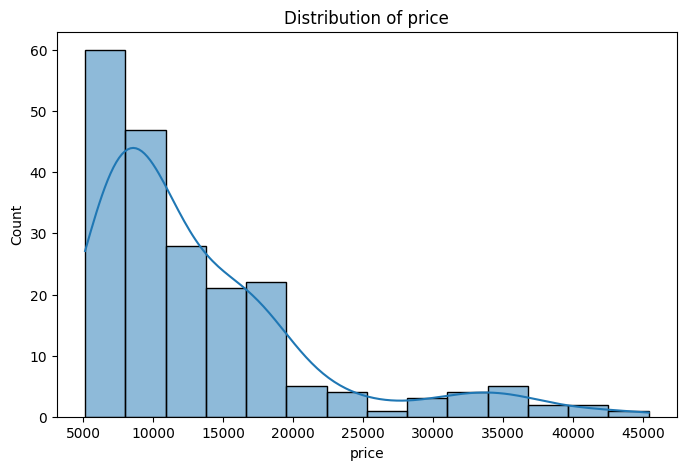

In [3]:
plt.figure(figsize=(8, 5))
sns.histplot(df[TARGET_COL], kde=True)
plt.title(f"Distribution of {TARGET_COL}")
plt.xlabel(TARGET_COL)
plt.ylabel("Count")
plt.show()

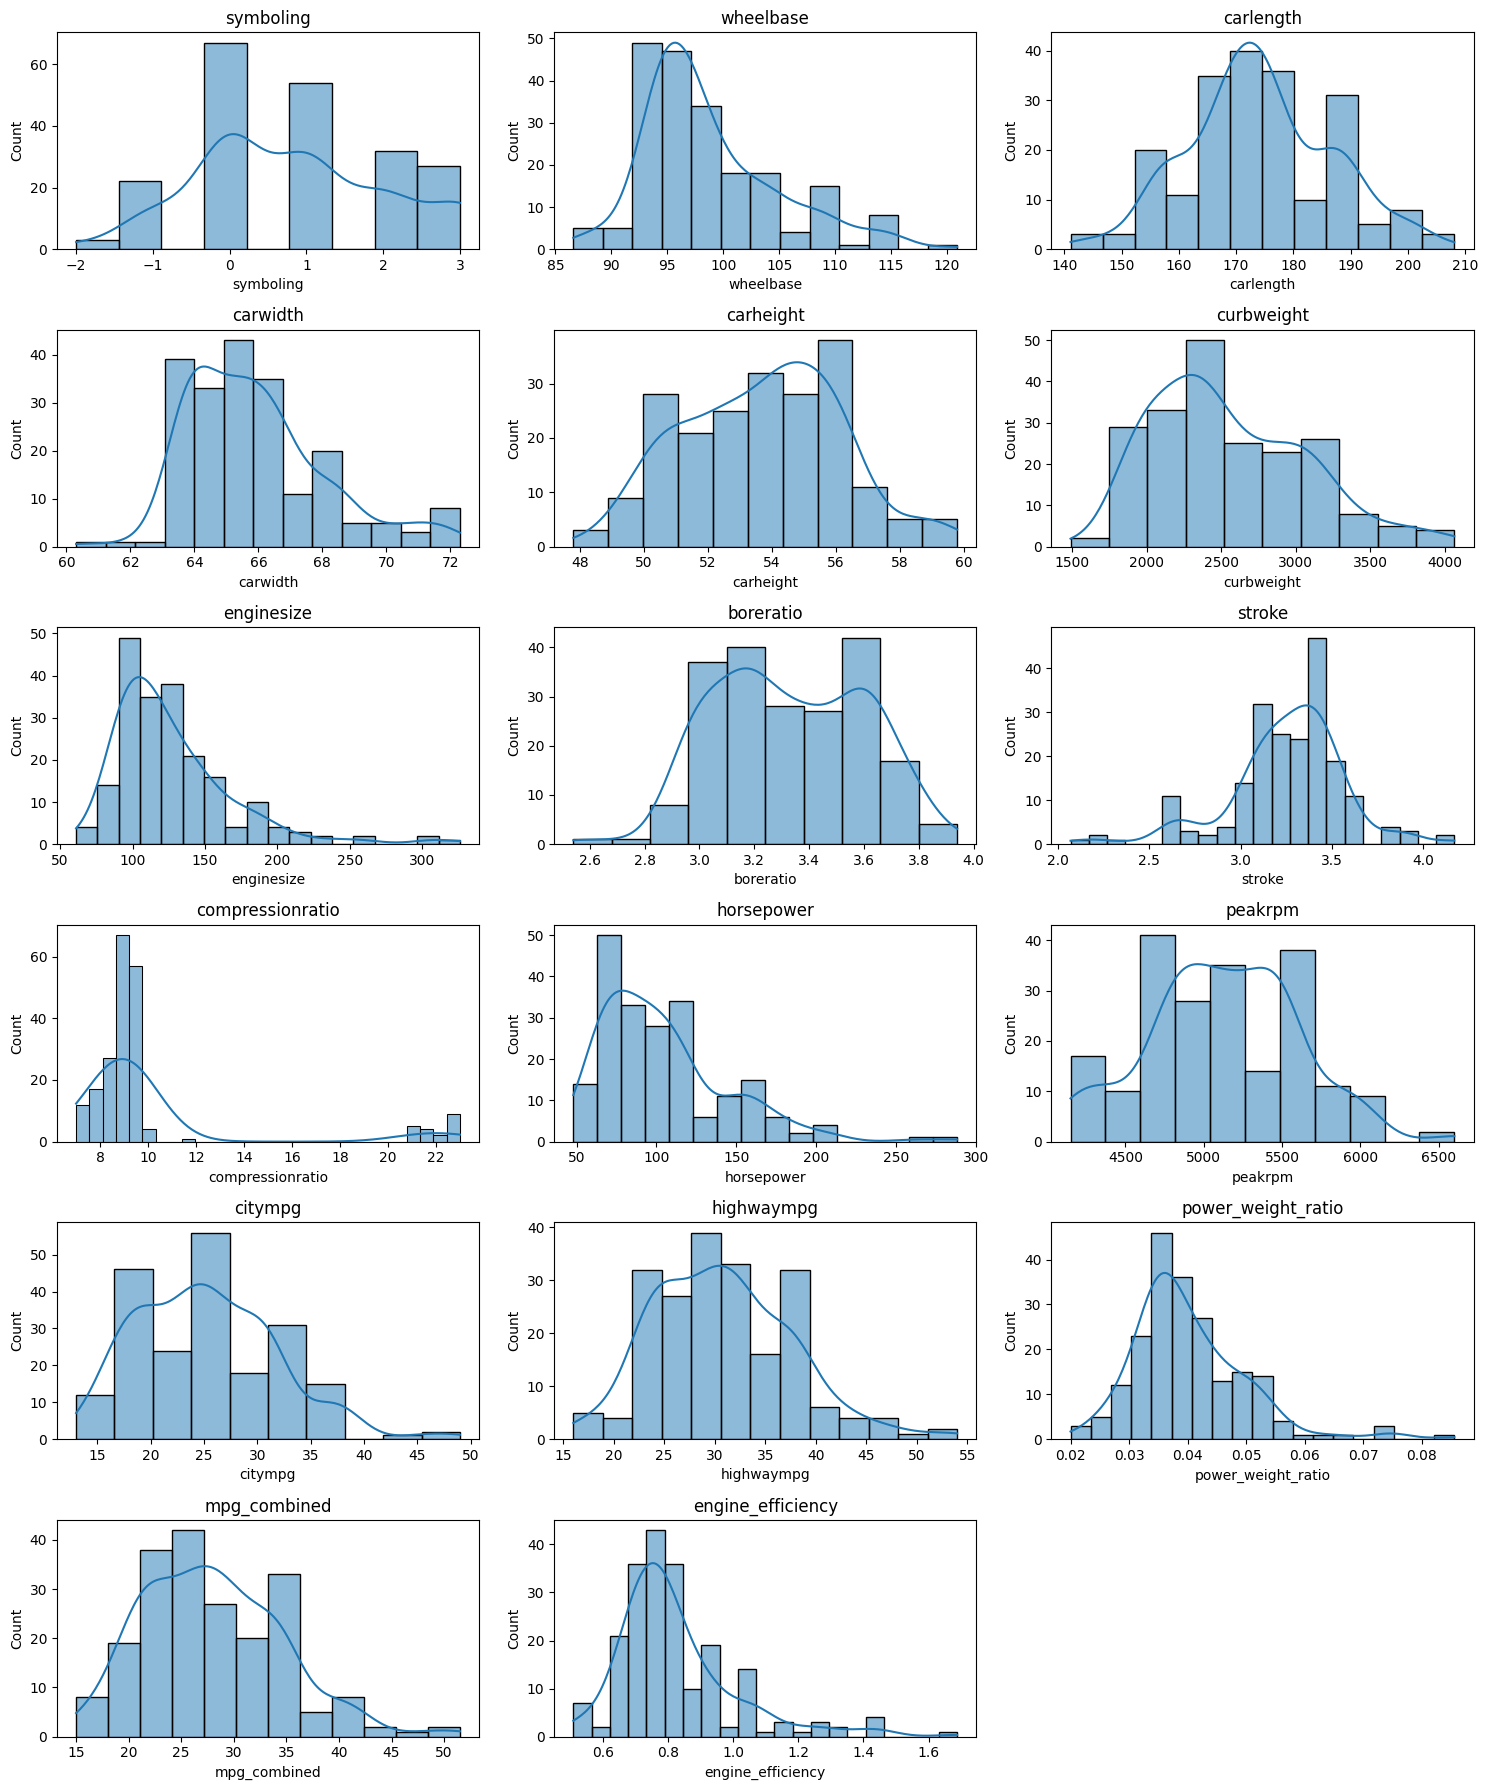

In [4]:
n_num = len(NUMERIC_FEATURES)
n_cols = 3
n_rows = int(np.ceil(n_num / n_cols))

plt.figure(figsize=(5 * n_cols, 3 * n_rows))

for i, col in enumerate(NUMERIC_FEATURES, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

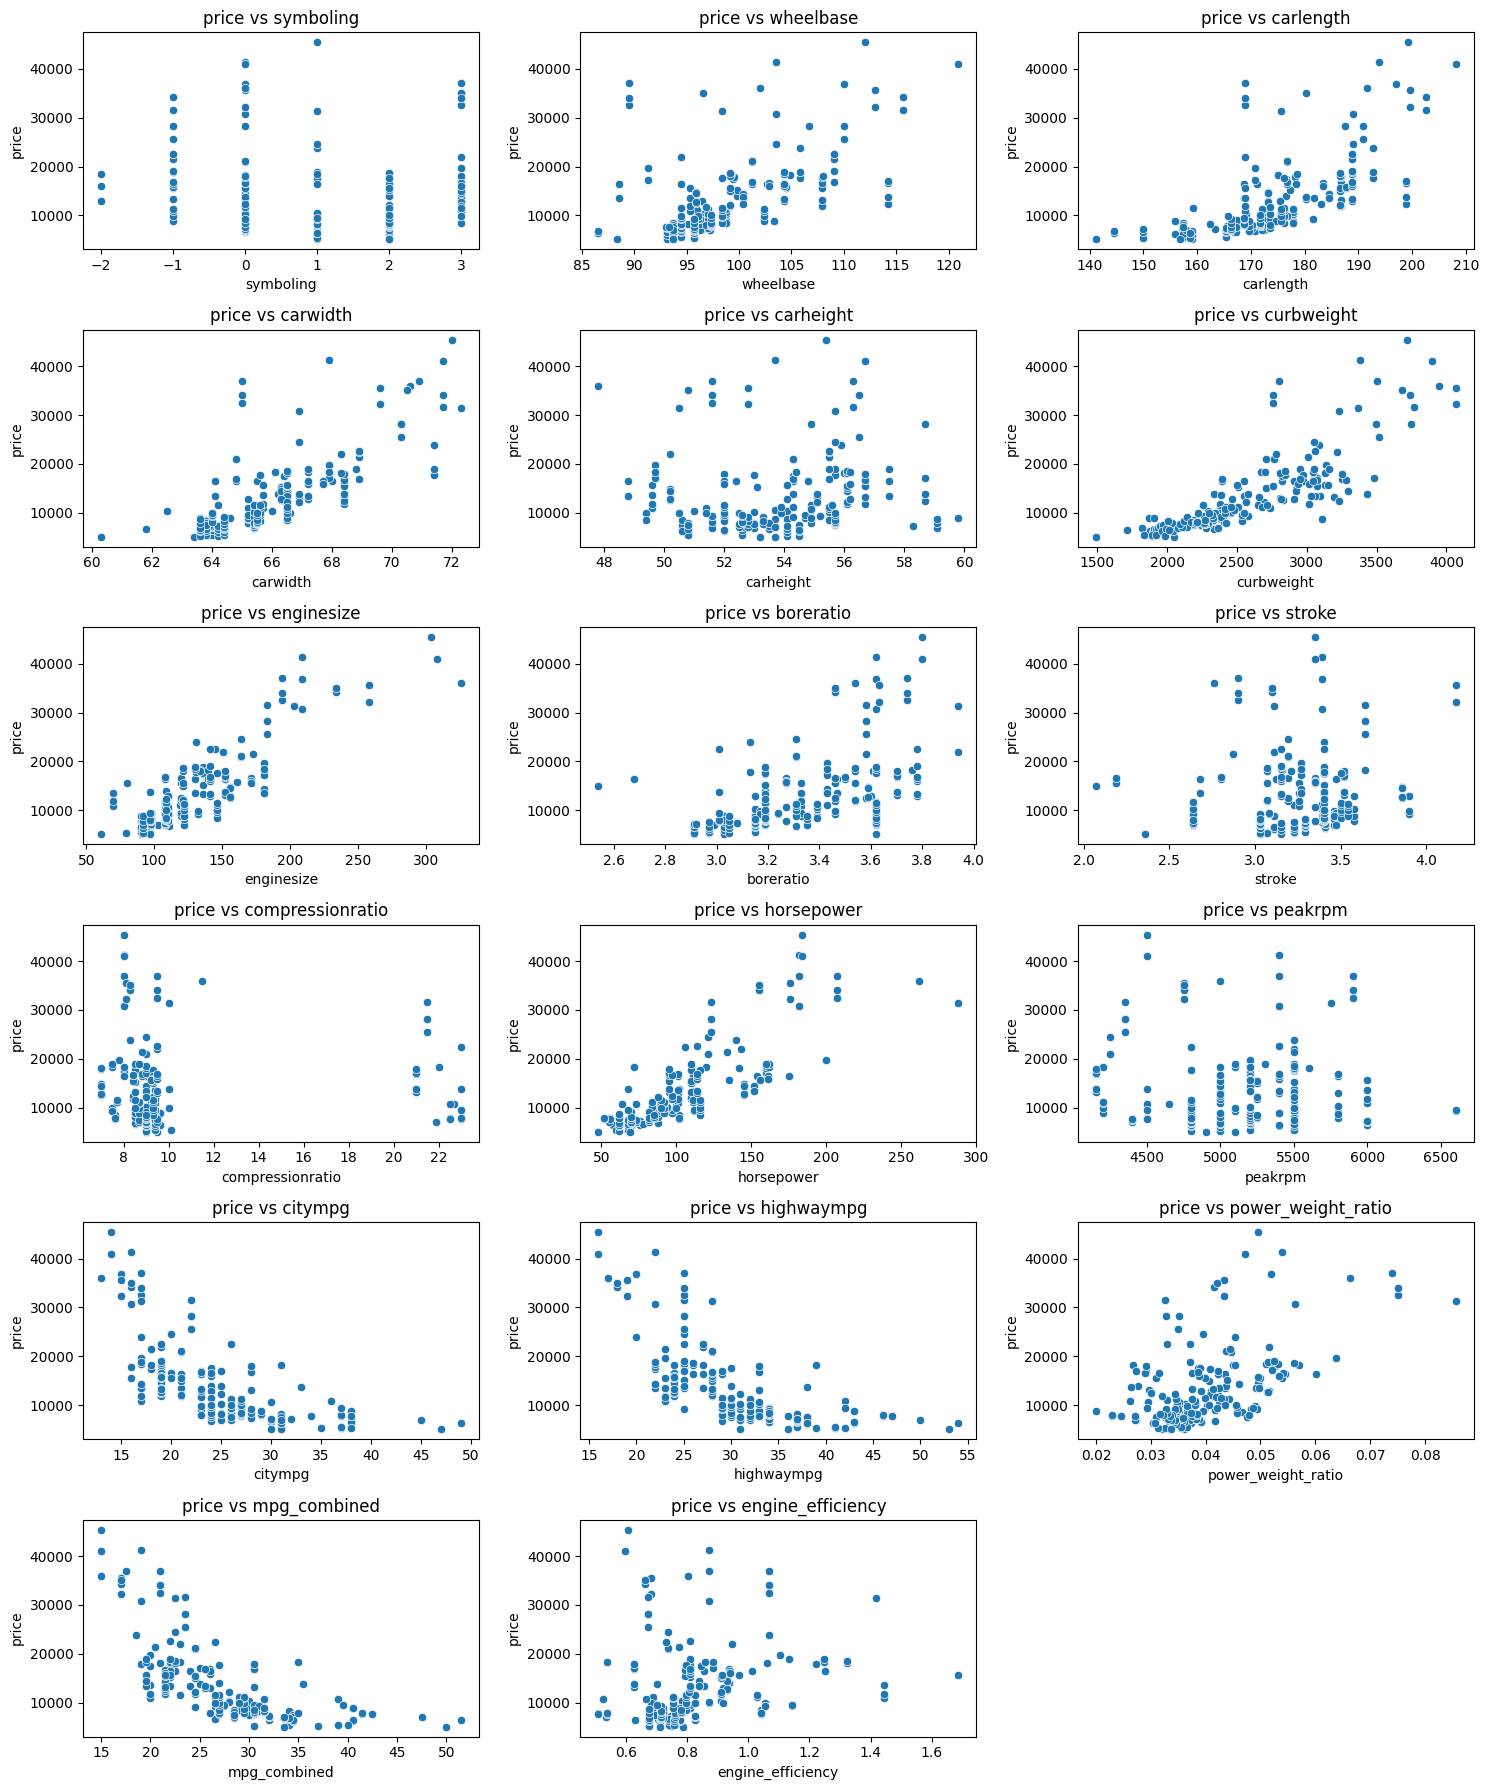

In [5]:
n_num = len(NUMERIC_FEATURES)
n_cols = 3
n_rows = int(np.ceil(n_num / n_cols))

plt.figure(figsize=(5 * n_cols, 3 * n_rows))

for i, col in enumerate(NUMERIC_FEATURES, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=df[col],y=TARGET_COL, data=df)
    plt.title(f"{TARGET_COL} vs {col}")
    plt.xlabel(col)
    plt.ylabel(TARGET_COL)

plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

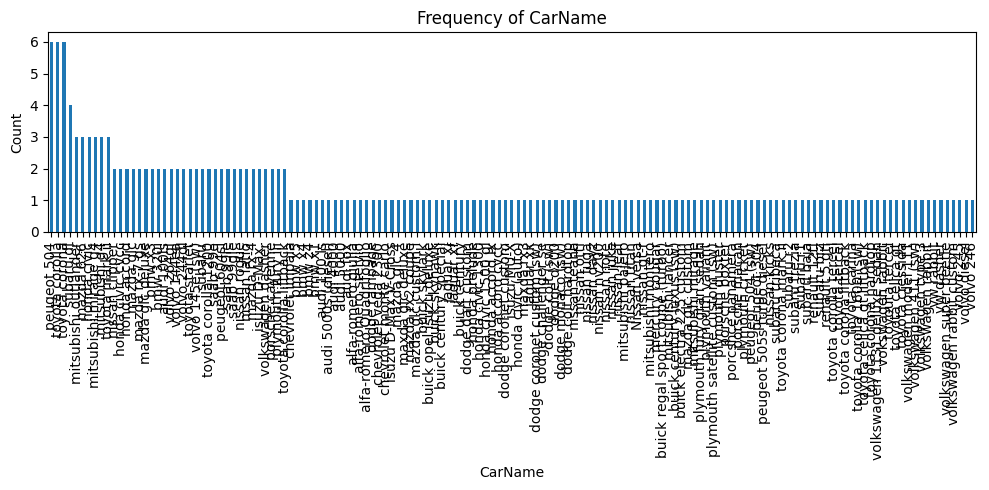

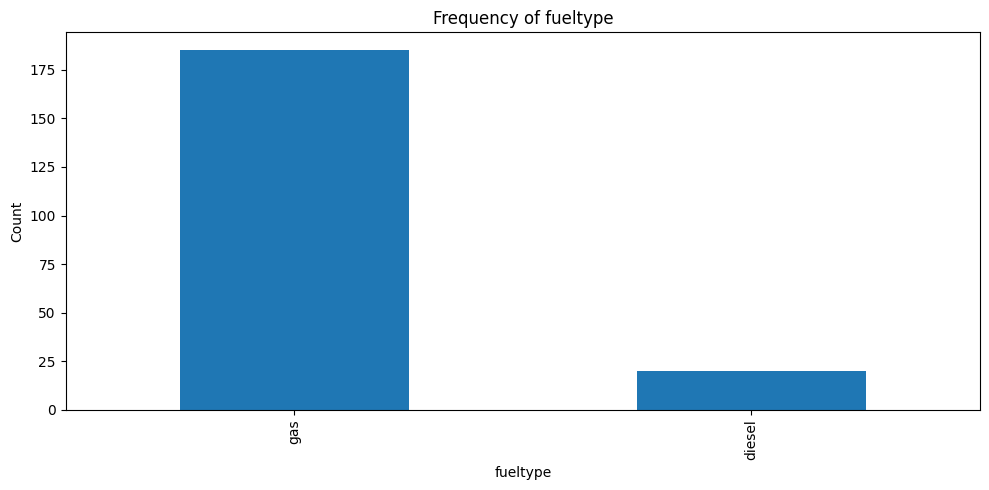

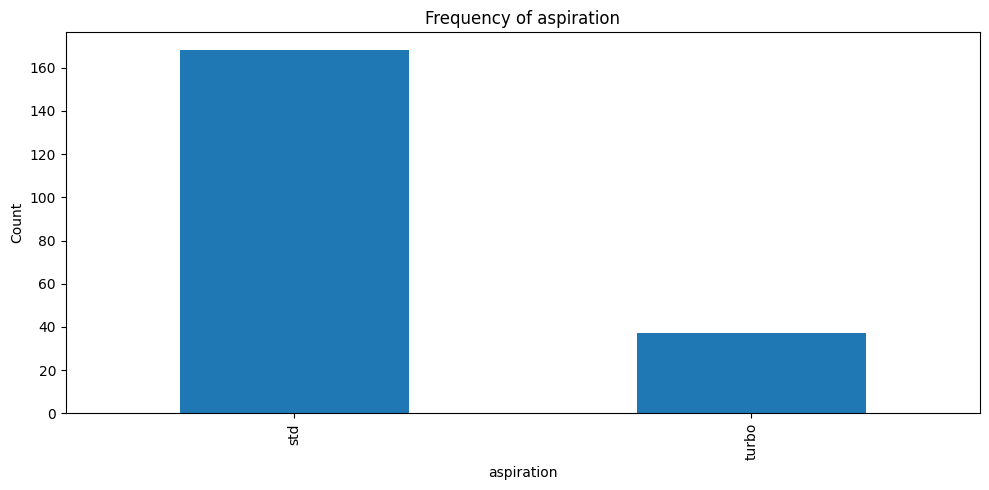

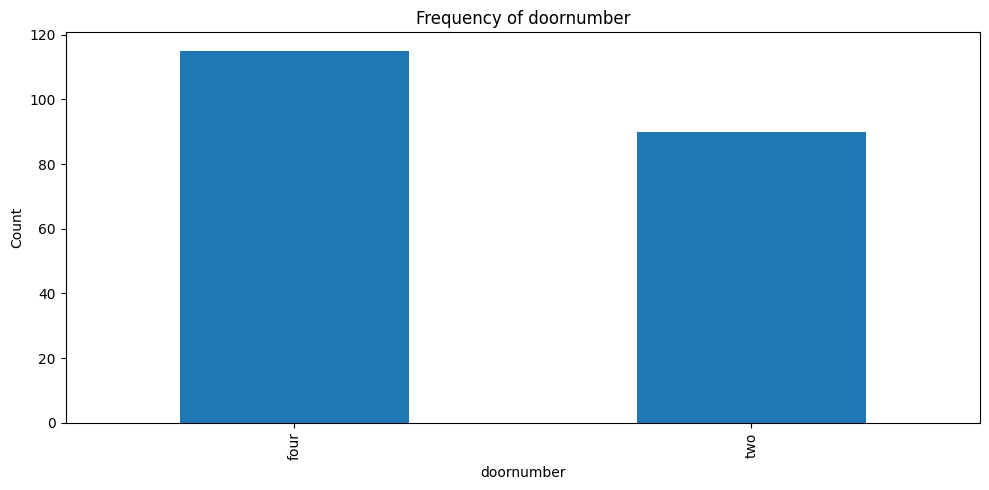

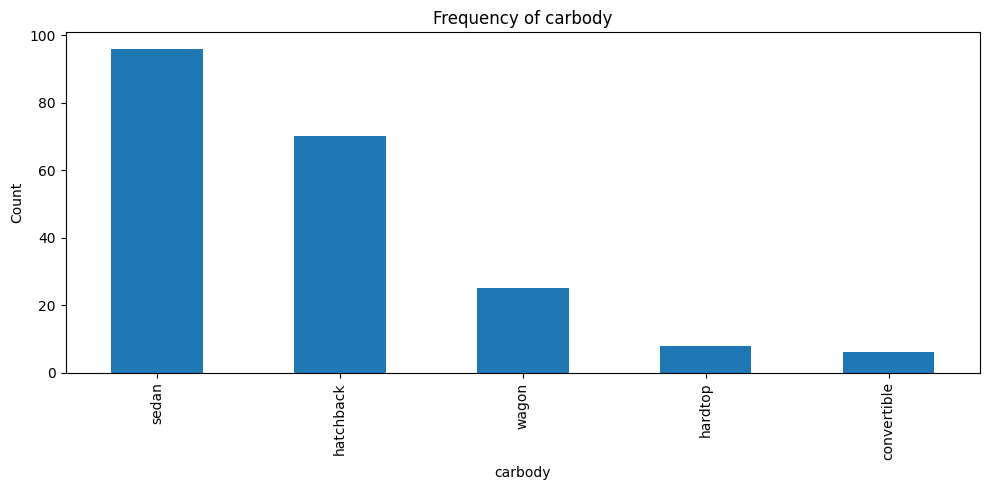

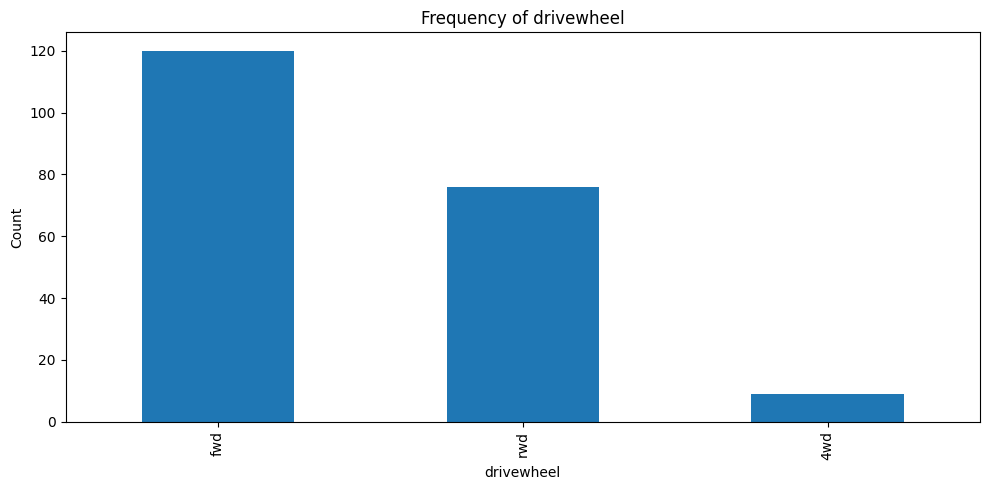

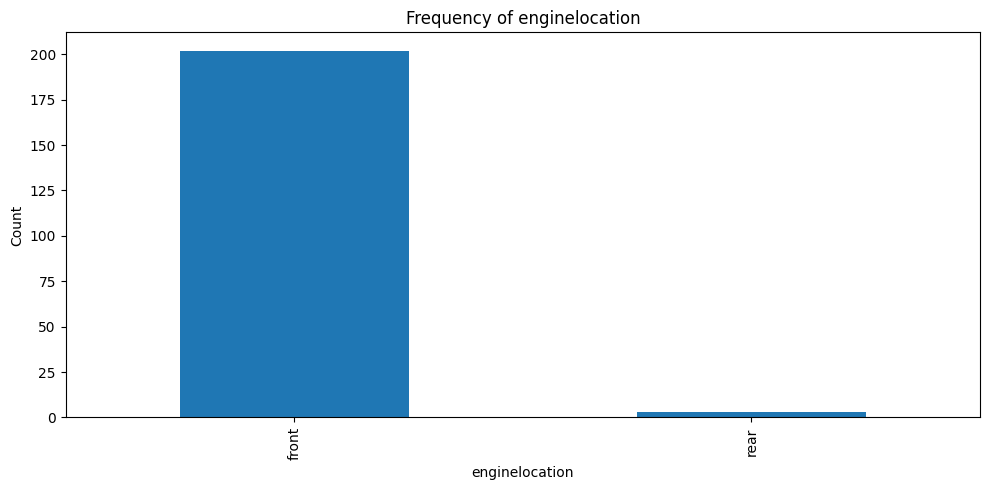

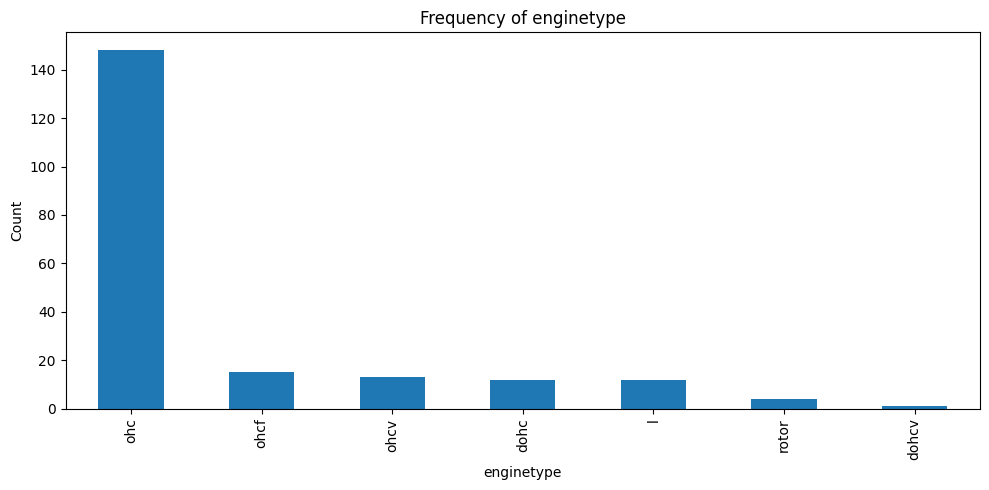

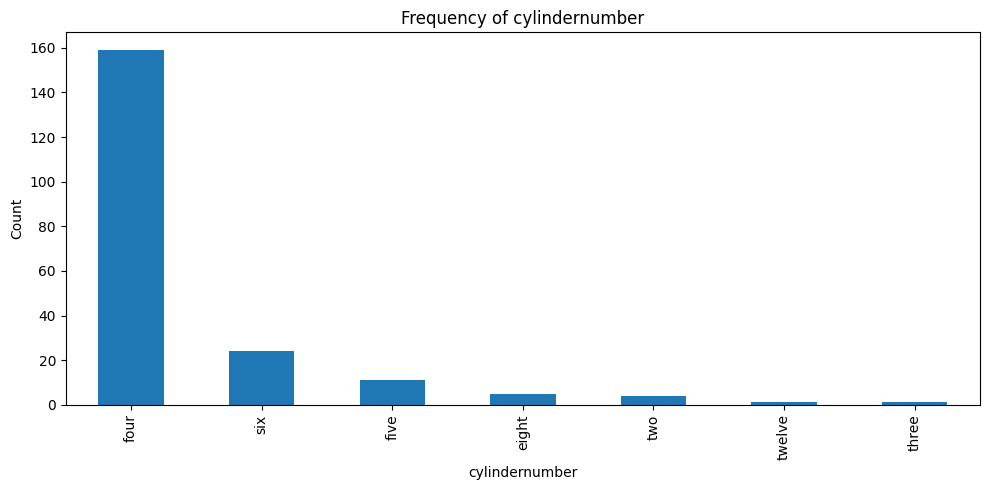

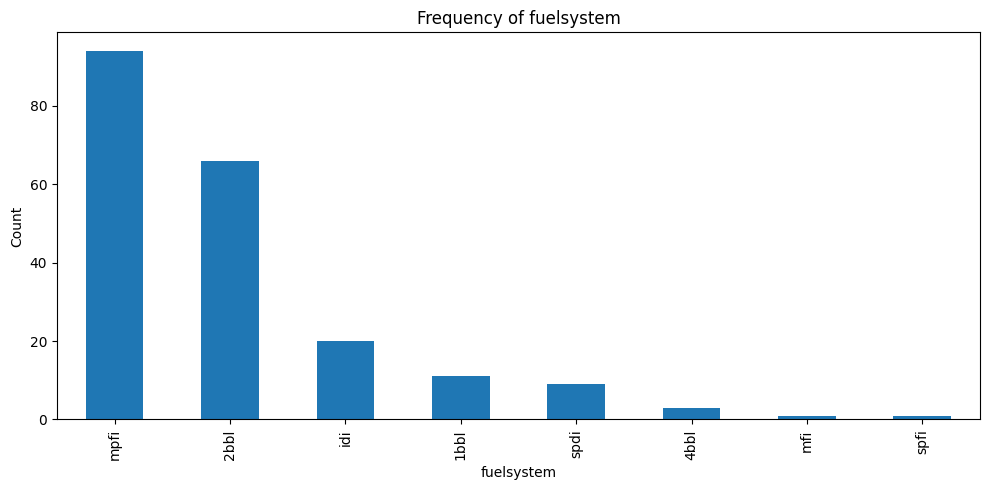

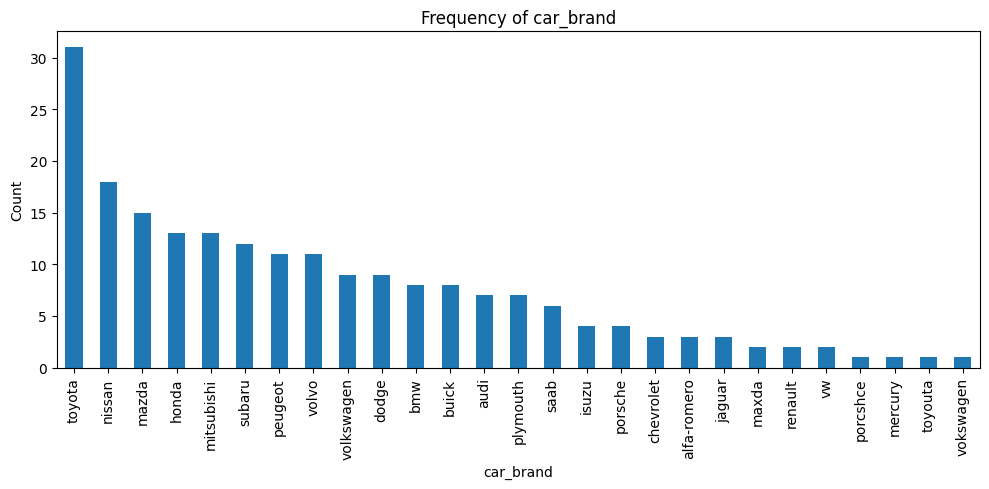

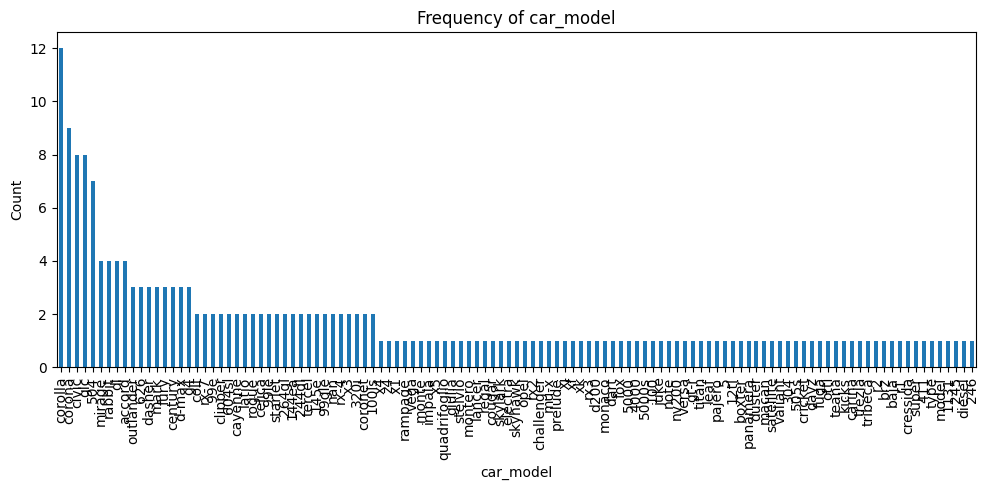

In [6]:
plt.figure(figsize=(10, 5))

for col in CATEGORICAL_FEATURES:
    plt.figure(figsize=(10, 5))
    df[col].value_counts(dropna=False).plot(kind="bar")
    plt.title(f"Frequency of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

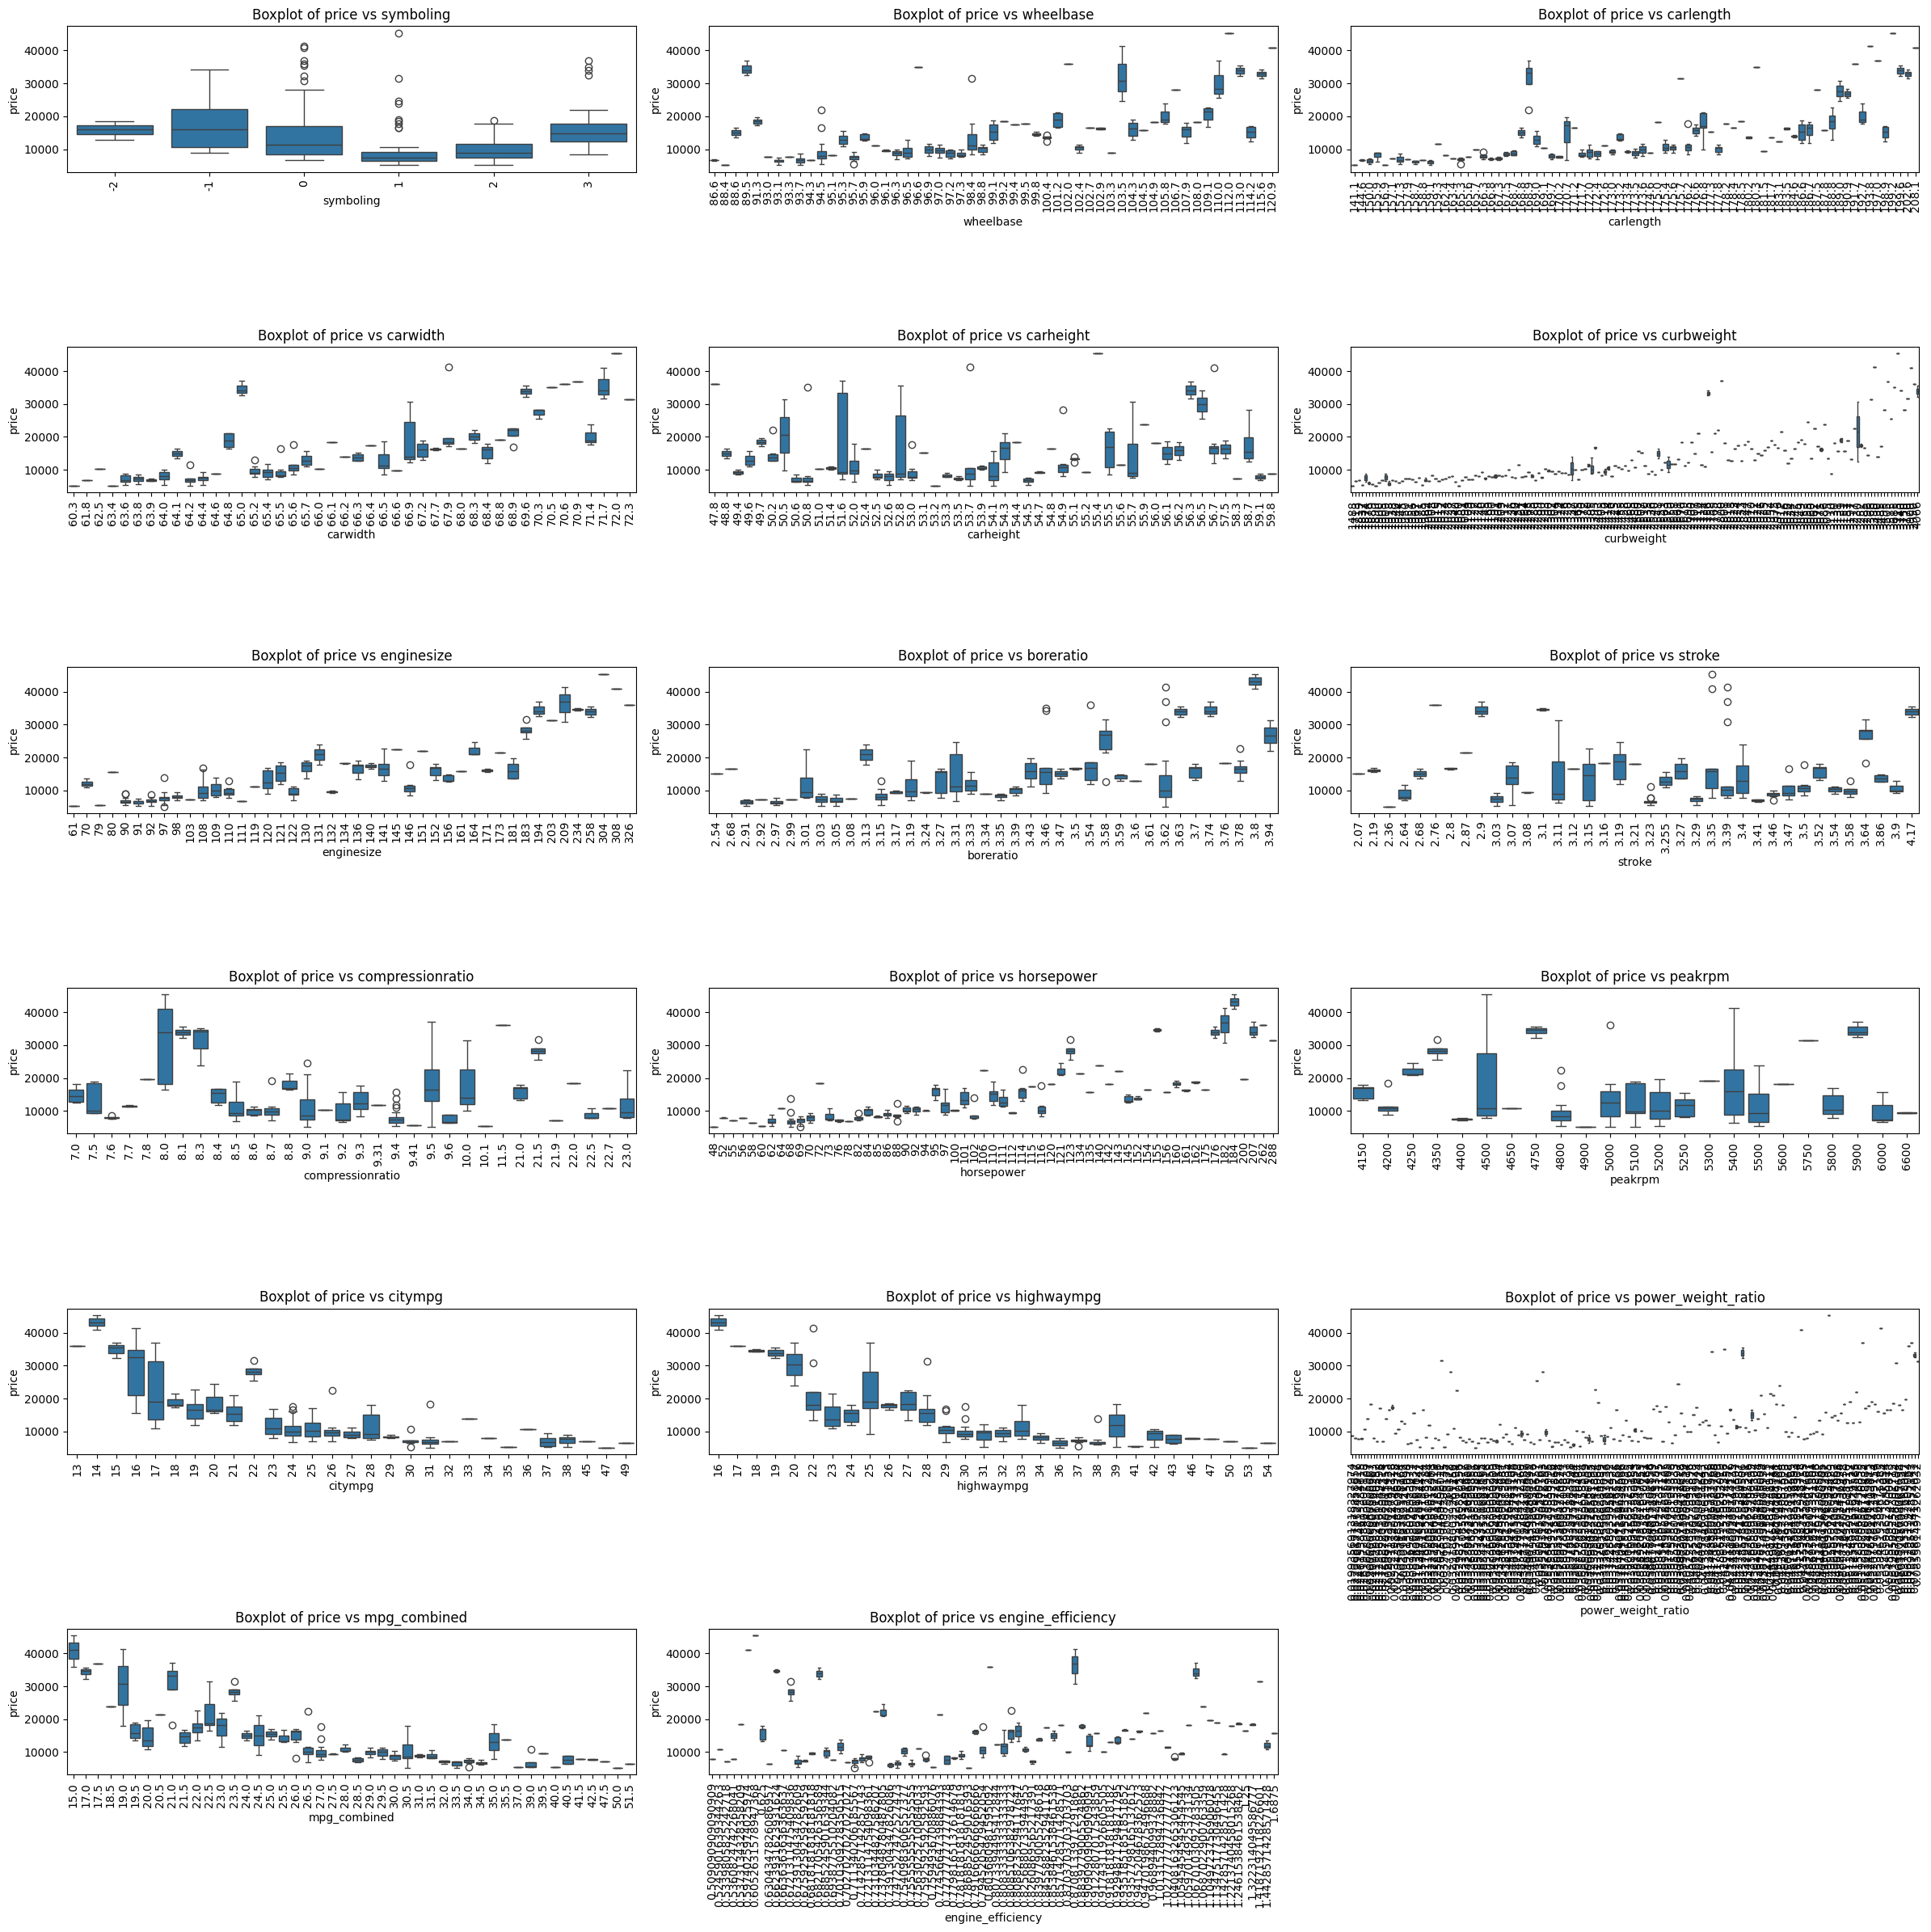

In [7]:
# Boxplots of Purchase Amount by Feature

n_num = len(NUMERIC_FEATURES)
n_cols = 3
n_rows = int(np.ceil(n_num / n_cols))

plt.figure(figsize=(8 * n_cols, 4 * n_rows))

for i, col in enumerate(NUMERIC_FEATURES, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col],y=TARGET_COL, data=df)
    plt.title(f"Boxplot of {TARGET_COL} vs {col}")
    plt.xlabel(col)
    plt.xticks(rotation=90)
    plt.ylabel(TARGET_COL)

plt.tight_layout()
plt.show()

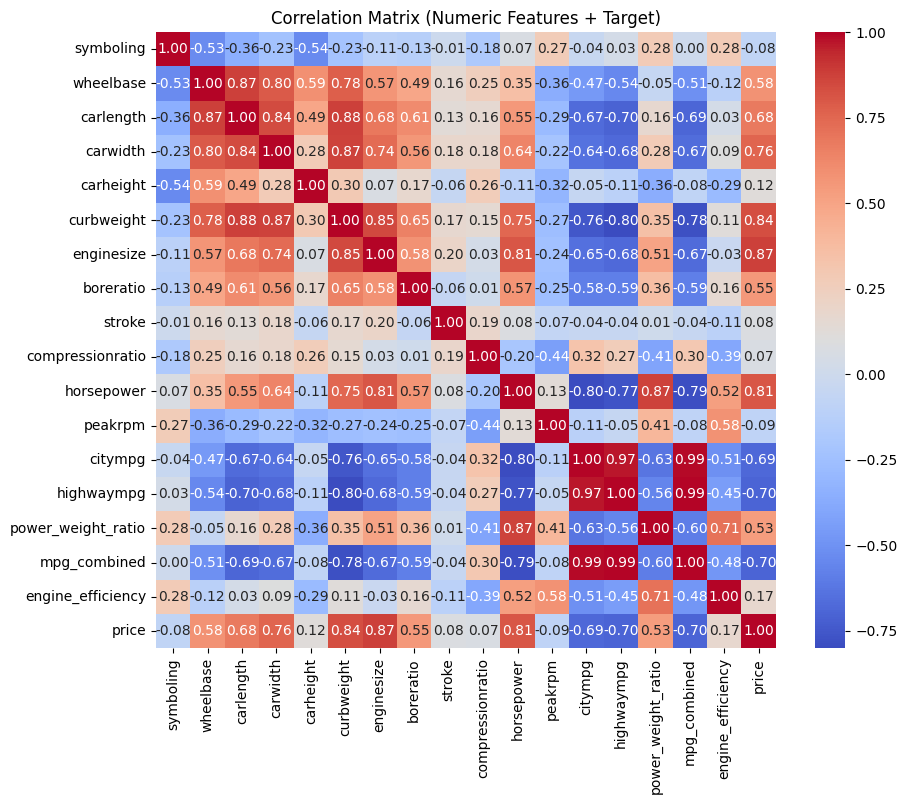

In [8]:
plt.figure(figsize=(10, 8))
corr = df[NUMERIC_FEATURES + [TARGET_COL]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features + Target)")
plt.show()

In [9]:
# Drop rows with NA in numeric features
X_num = df[NUMERIC_FEATURES].dropna().copy()

vif_df = pd.DataFrame()
vif_df["feature"] = X_num.columns
vif_df["VIF"] = [
    variance_inflation_factor(X_num.values, i) 
    for i in range(X_num.shape[1])
]

vif_df.sort_values("VIF", ascending=False)


c:\Users\rich_\OneDrive\customer_spend_model\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
13,highwaympg,inf
12,citympg,inf
15,mpg_combined,inf
3,carwidth,3063.231405
1,wheelbase,2374.321152
2,carlength,1896.997110
5,curbweight,1150.274712
14,power_weight_ratio,1054.127404
4,carheight,1013.012305
10,horsepower,924.845643
